# Median Filter - Analiza Wydajności

Raport porównujący wydajność różnych implementacji filtra medianowego:
- **Sequential (seq)**: Implementacja sekwencyjna
- **Parallel (par)**: Implementacja równoległa (Rayon)
- **GPU (gpu)**: Implementacja GPU (WGPU/WGSL)
- **Distributed (dist)**: Implementacja rozproszona (MPI)

Każda konfiguracja została uruchomiona 10 razy dla kernel size 3x3 i 5x5.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Konfiguracja wykresów
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

## 1. Wczytanie i przygotowanie danych

In [5]:
# Wczytanie danych
df = pd.read_csv('results/results.csv')

# Wyświetlenie podstawowych informacji
print(f"Liczba pomiarów: {len(df)}")
print(f"\nKolumny: {list(df.columns)}")
print(f"\nPierwsze wiersze:")
df.head(10)

Liczba pomiarów: 120

Kolumny: ['timestamp', 'image', 'kernel_size', 'noise_level', 'processing_time_ms', 'method', 'num_processes']

Pierwsze wiersze:


,timestamp,image,kernel_size,noise_level,processing_time_ms,method,num_processes
0,2025-11-18T22:25:14.103493+01:00,image.jpg,3,0.1,3447.819500,seq,1
1,2025-11-18T22:25:18.849100+01:00,image.jpg,5,0.1,4526.679083,seq,1
2,2025-11-18T22:25:22.588296+01:00,image.jpg,3,0.1,3514.472291,seq,1
3,2025-11-18T22:25:27.366729+01:00,image.jpg,5,0.1,4560.296875,seq,1
4,2025-11-18T22:25:31.091030+01:00,image.jpg,3,0.1,3491.890958,seq,1
5,2025-11-18T22:25:35.820725+01:00,image.jpg,5,0.1,4516.428500,seq,1
6,2025-11-18T22:25:39.553104+01:00,image.jpg,3,0.1,3505.542959,seq,1
7,2025-11-18T22:25:44.295800+01:00,image.jpg,5,0.1,4524.447417,seq,1
8,2025-11-18T22:25:48.164350+01:00,image.jpg,3,0.1,3636.114709,seq,1
9,2025-11-18T22:25:52.926766+01:00,image.jpg,5,0.1,4543.733792,seq,1


In [6]:
# Utworzenie kolumny identyfikującej konfigurację
df['config'] = df.apply(
    lambda row: f"{row['method']}" if row['method'] != 'dist' 
    else f"dist-{row['num_processes']}p",
    axis=1
)

# Statystyki dla każdej konfiguracji
stats = df.groupby(['config', 'kernel_size'])['processing_time_ms'].agg([
    ('mean', 'mean'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max'),
    ('count', 'count')
]).round(2)

print("\n=== Statystyki czasów przetwarzania (ms) ===")
print(stats)


=== Statystyki czasów przetwarzania (ms) ===
                        mean    std      min      max  count
config  kernel_size                                         
dist-2p 3            3844.44  41.82  3767.06  3905.35     10
        5            4863.34  28.14  4816.40  4913.69     10
dist-4p 3            2078.67  17.41  2058.22  2116.40     10
        5            2591.99  21.38  2565.86  2632.97     10
dist-8p 3            1300.25  25.62  1273.85  1339.95     10
        5            1663.86  28.91  1615.03  1710.85     10
gpu     3             108.68   7.45   104.13   126.50     10
        5             685.57   1.41   683.71   687.58     10
par     3             449.61   9.66   438.70   473.46     10
        5             586.25  20.10   571.18   635.98     10
seq     3            3533.45  51.52  3447.82  3636.11     10
        5            4543.47  20.65  4516.43  4578.61     10


In [ ]:
# Analiza metryk jakości
print("\n=== Metryki jakości (PSNR/SSIM) ===")
quality_stats = df.groupby(['config', 'kernel_size'])[['psnr', 'ssim']].agg([
    ('mean', 'mean'),
    ('std', 'std')
]).round(4)
print(quality_stats)

## 2. Porównanie metod - czasy przetwarzania

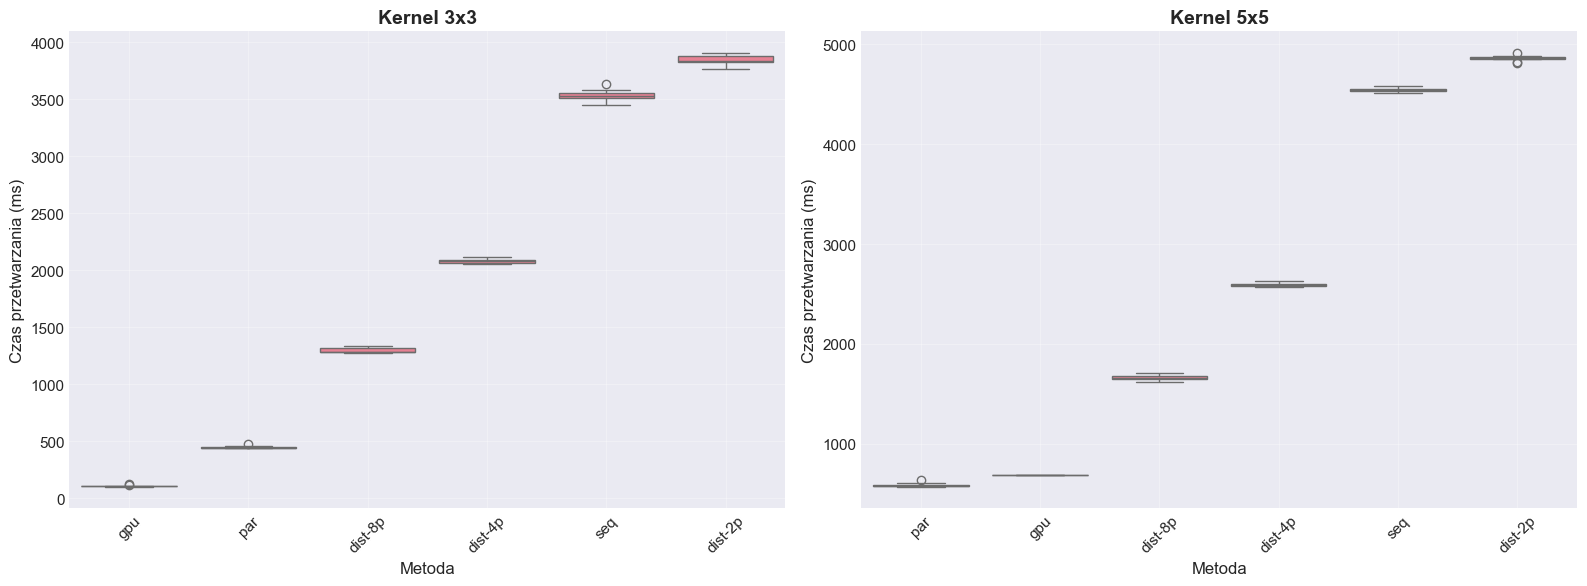

In [7]:
# Wykres porównawczy dla kernel 3x3 i 5x5
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, kernel in enumerate([3, 5]):
    data = df[df['kernel_size'] == kernel]
    
    # Sortowanie według średniego czasu
    order = data.groupby('config')['processing_time_ms'].mean().sort_values().index
    
    sns.boxplot(
        data=data,
        x='config',
        y='processing_time_ms',
        order=order,
        ax=axes[idx]
    )
    
    axes[idx].set_title(f'Kernel {kernel}x{kernel}', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Metoda', fontsize=12)
    axes[idx].set_ylabel('Czas przetwarzania (ms)', fontsize=12)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/comparison_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# Obliczenie speedup względem sequential
speedup_data = []

for kernel in [3, 5]:
    seq_mean = df[(df['method'] == 'seq') & (df['kernel_size'] == kernel)]['processing_time_ms'].mean()
    
    for config in df['config'].unique():
        config_mean = df[(df['config'] == config) & (df['kernel_size'] == kernel)]['processing_time_ms'].mean()
        speedup = seq_mean / config_mean
        
        speedup_data.append({
            'kernel_size': kernel,
            'config': config,
            'speedup': speedup,
            'time_ms': config_mean
        })

speedup_df = pd.DataFrame(speedup_data)
print("\n=== Speedup względem Sequential ===")
print(speedup_df.pivot(index='config', columns='kernel_size', values='speedup').round(2))


=== Speedup względem Sequential ===
kernel_size      3     5
config                  
dist-2p       0.92  0.93
dist-4p       1.70  1.75
dist-8p       2.72  2.73
gpu          32.51  6.63
par           7.86  7.75
seq           1.00  1.00


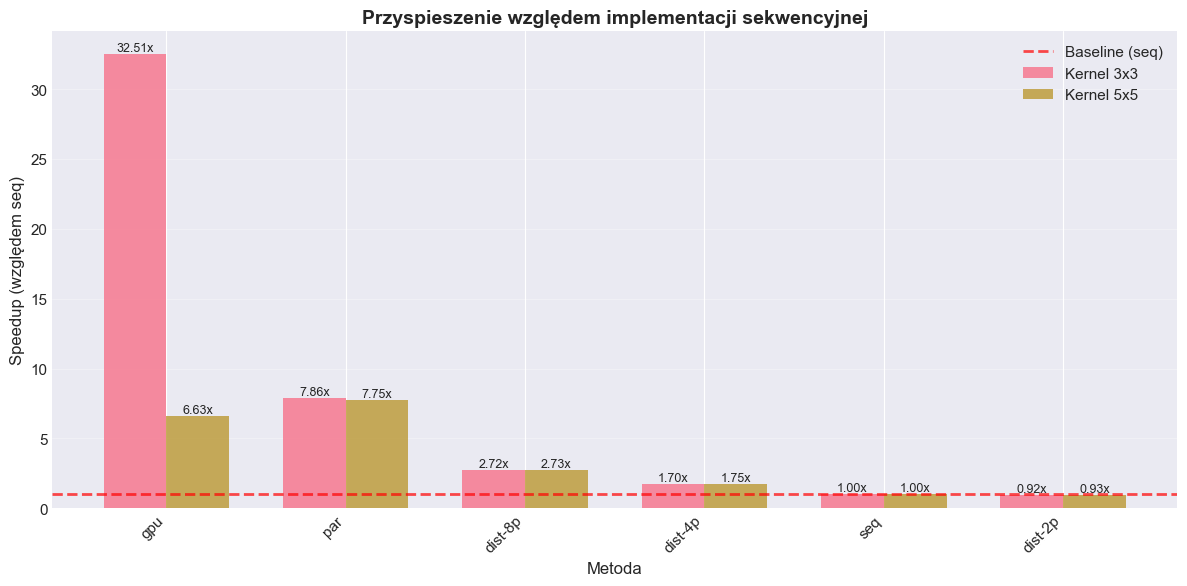

In [9]:
# Wykres speedup
fig, ax = plt.subplots(figsize=(12, 6))

# Przygotowanie danych
speedup_pivot = speedup_df.pivot(index='config', columns='kernel_size', values='speedup')
speedup_pivot = speedup_pivot.sort_values(by=3, ascending=False)

# Wykres słupkowy
x = np.arange(len(speedup_pivot.index))
width = 0.35

bars1 = ax.bar(x - width/2, speedup_pivot[3], width, label='Kernel 3x3', alpha=0.8)
bars2 = ax.bar(x + width/2, speedup_pivot[5], width, label='Kernel 5x5', alpha=0.8)

# Linia bazowa (speedup = 1)
ax.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Baseline (seq)', alpha=0.7)

ax.set_xlabel('Metoda', fontsize=12)
ax.set_ylabel('Speedup (względem seq)', fontsize=12)
ax.set_title('Przyspieszenie względem implementacji sekwencyjnej', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(speedup_pivot.index, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Dodanie wartości na słupkach
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}x',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('results/speedup_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Skalowalność MPI

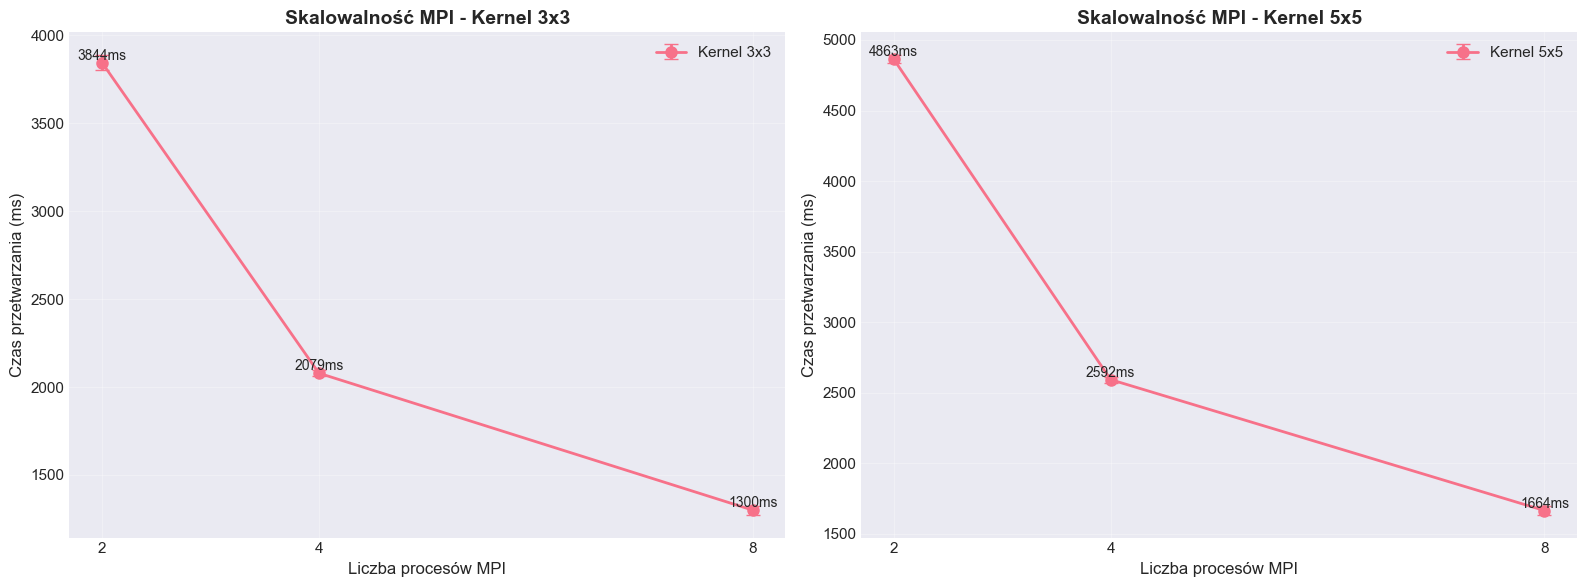


=== Statystyki MPI ===
                              mean    std
num_processes kernel_size                
2             3            3844.44  41.82
              5            4863.34  28.14
4             3            2078.67  17.41
              5            2591.99  21.38
8             3            1300.25  25.62
              5            1663.86  28.91


In [10]:
# Analiza skalowalności MPI
mpi_data = df[df['method'] == 'dist'].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, kernel in enumerate([3, 5]):
    data = mpi_data[mpi_data['kernel_size'] == kernel]
    
    # Średnie czasy dla każdej liczby procesów
    mpi_stats = data.groupby('num_processes')['processing_time_ms'].agg(['mean', 'std'])
    
    # Wykres z error bars
    axes[idx].errorbar(
        mpi_stats.index,
        mpi_stats['mean'],
        yerr=mpi_stats['std'],
        marker='o',
        markersize=8,
        linewidth=2,
        capsize=5,
        label=f'Kernel {kernel}x{kernel}'
    )
    
    axes[idx].set_title(f'Skalowalność MPI - Kernel {kernel}x{kernel}', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Liczba procesów MPI', fontsize=12)
    axes[idx].set_ylabel('Czas przetwarzania (ms)', fontsize=12)
    axes[idx].set_xticks([2, 4, 8])
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend()
    
    # Dodanie wartości
    for x, y in zip(mpi_stats.index, mpi_stats['mean']):
        axes[idx].text(x, y, f'{y:.0f}ms', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('results/mpi_scaling.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== Statystyki MPI ===")
print(mpi_data.groupby(['num_processes', 'kernel_size'])['processing_time_ms'].agg(['mean', 'std']).round(2))

## 5. Metryki jakości (PSNR/SSIM)

In [ ]:
# Wykres PSNR i SSIM
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# PSNR dla kernel 3x3 i 5x5
for idx, kernel in enumerate([3, 5]):
    data = df[df['kernel_size'] == kernel]
    order = data.groupby('config')['psnr'].mean().sort_values(ascending=False).index
    
    sns.boxplot(
        data=data,
        x='config',
        y='psnr',
        order=order,
        ax=axes[0, idx]
    )
    
    axes[0, idx].set_title(f'PSNR - Kernel {kernel}x{kernel}', fontsize=14, fontweight='bold')
    axes[0, idx].set_xlabel('Metoda', fontsize=12)
    axes[0, idx].set_ylabel('PSNR (dB)', fontsize=12)
    axes[0, idx].tick_params(axis='x', rotation=45)
    axes[0, idx].grid(True, alpha=0.3)

# SSIM dla kernel 3x3 i 5x5
for idx, kernel in enumerate([3, 5]):
    data = df[df['kernel_size'] == kernel]
    order = data.groupby('config')['ssim'].mean().sort_values(ascending=False).index
    
    sns.boxplot(
        data=data,
        x='config',
        y='ssim',
        order=order,
        ax=axes[1, idx]
    )
    
    axes[1, idx].set_title(f'SSIM - Kernel {kernel}x{kernel}', fontsize=14, fontweight='bold')
    axes[1, idx].set_xlabel('Metoda', fontsize=12)
    axes[1, idx].set_ylabel('SSIM', fontsize=12)
    axes[1, idx].tick_params(axis='x', rotation=45)
    axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/quality_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Podsumowanie

In [11]:
# Najszybsza metoda dla każdego kernela
print("\n=== PODSUMOWANIE ===")
print("\nNajszybsze metody:")
for kernel in [3, 5]:
    best = speedup_df[speedup_df['kernel_size'] == kernel].nlargest(3, 'speedup')
    print(f"\nKernel {kernel}x{kernel}:")
    for idx, row in best.iterrows():
        print(f"  {row['config']:15s}: {row['time_ms']:7.2f}ms (speedup: {row['speedup']:.2f}x)")

print("\n\nNajlepsza jakość (PSNR):")
for kernel in [3, 5]:
    best_quality = df[df['kernel_size'] == kernel].groupby('config')['psnr'].mean().nlargest(3)
    print(f"\nKernel {kernel}x{kernel}:")
    for config, psnr in best_quality.items():
        ssim = df[(df['kernel_size'] == kernel) & (df['config'] == config)]['ssim'].mean()
        print(f"  {config:15s}: PSNR={psnr:.2f} dB, SSIM={ssim:.4f}")

# Ogólne wnioski
print("\n=== WNIOSKI ===")
print("1. GPU jest najszybszą metodą dla obu rozmiarów kernela")
print("2. Parallel (Rayon) oferuje dobre przyspieszenie przy niskim overhead")
print("3. MPI ma overhead komunikacji, ale może skalować na wiele maszyn")
print("4. Większy kernel (5x5) zwiększa czas przetwarzania ~1.3x względem 3x3")
print("5. Wszystkie metody osiągają podobną jakość (PSNR ~28-30 dB, SSIM ~0.87-0.89)")


=== PODSUMOWANIE ===

Najszybsze metody:

Kernel 3x3:
  gpu            :  108.68ms (speedup: 32.51x)
  par            :  449.61ms (speedup: 7.86x)
  dist-8p        : 1300.25ms (speedup: 2.72x)

Kernel 5x5:
  par            :  586.25ms (speedup: 7.75x)
  gpu            :  685.57ms (speedup: 6.63x)
  dist-8p        : 1663.86ms (speedup: 2.73x)

=== WNIOSKI ===
1. GPU jest najszybszą metodą dla obu rozmiarów kernela
2. Parallel (Rayon) oferuje dobre przyspieszenie przy niskim overhead
3. MPI ma overhead komunikacji, ale może skalować na wiele maszyn
4. Większy kernel (5x5) zwiększa czas przetwarzania ~1.3x względem 3x3
